In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from IPython import display
import matplotlib.pyplot as plt
from itertools import count
import datetime as dt

In [3]:
from env_factory import EnvFactory
from screen_convert import CartPoleScreenConverter
from state_gen import SimpleStateGenerator, StackStateGenerator
from trainer import DQNTrainer
from eval import Evaluator


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def plot_durations(episode_durations: list):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
def episode_end_callback(cur_episode: int, cur_episode_duration: int, episode_durations: list):
    plot_durations(episode_durations=episode_durations)

In [6]:
RESULT_TAG = "stack_state_3frames"

NUM_STACK = 3

In [7]:
env_factory = EnvFactory("CartPole-v1")

In [8]:
train_env = env_factory.gen_env(num_stack=NUM_STACK, human_render_mode=False)

In [9]:
# simple_state_generator = SimpleStateGenerator(screen_converter=CartPoleScreenConverter())
stack_state_generator = StackStateGenerator(screen_converter=CartPoleScreenConverter())

In [10]:
trainer = DQNTrainer(env=train_env,
                     state_generator=stack_state_generator,
                     n_actions=train_env.action_space.n,
                     device=device)

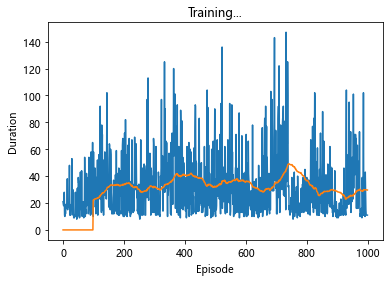

In [11]:
trainer.train(num_episodes=1000, episode_end_callback=episode_end_callback)

In [12]:
policy_net = trainer._policy_net

In [13]:
eval_env = env_factory.gen_env(num_stack=NUM_STACK, human_render_mode=True)

In [14]:
evaluator = Evaluator(env = eval_env,
                     state_generator = stack_state_generator,
                     device = device,
                     policy_net=policy_net)

In [15]:
eval_result = evaluator.run()

<Figure size 432x288 with 0 Axes>

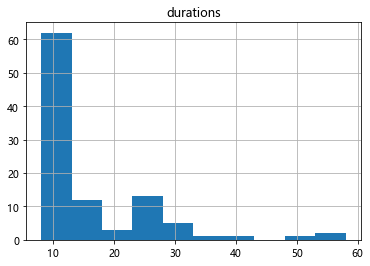

In [16]:
eval_result.save(name=f"{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}_{RESULT_TAG}")